In [2]:
import seaborn as sns

import sklearn
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import consensus_score

import scipy.linalg
from functools import partial
%pylab
%matplotlib inline
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
from __future__ import print_function
import gc
from tqdm import tqdm_notebook as tqdm
from __future__ import division
import pandas as pd
import seaborn as sb
import os
from scipy.spatial import distance
from scipy.cluster import hierarchy
from pandas import DataFrame

import os, sys, datetime
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

import passivity_2p_imaging_utils as p2putils
import visualization_utils as vizutil
import matplotlib.cm as cm
from matplotlib.colors import Normalize
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

fishIdx = [("e", 2),  ("e", 5), ("c", 1),  ("c", 6),  ("enp", 1), ("enp", 5)]



import tensorflow as tf
from scipy import signal

# tf.enable_eager_execution()


# df, sig = f.get_cnmf_roi_table_and_signals()


# data = np.load("../cnmf_f01555.npz")
# cnmf = data['cnmf'].astype(np.float32)
# raw = data['raw'].astype(np.float32)
# del data

def moving_average(a, n=3):
    # a is a signal
    ret = np.cumsum(a,0) # sum over time
    ret[n:] = ret[n:] - ret[:-n] # diff of n samples back
    rm = ret[n - 1:] / n
    pad_start = np.full((n-1,rm.shape[1]), rm[0])
    return np.vstack([pad_start, rm])

def ewma(data,span):
    "exponential weighted moving average."
    df = DataFrame(data)
    return df.ewm(span).mean().values

def df_f(x,ma_window=6,span=6):
    u = moving_average(x,ma_window)
    return ewma((x - u)/u, span)

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [107]:
def read_fish_data(indicator):
    f = all_data[fishIdx[indicator][0]][fishIdx[indicator][1]]
    M = f.get_signals_raw(z=None)
    neurons = M.T

    # neuron_ids = np.sort(np.argsort(neurons.std(0))[-5000:])
    df = f.get_roi_table()
    # df = df.iloc[neuron_ids]
    # df.reset_index(drop=True, inplace=True)
    # neurons = neurons[:,neuron_ids]


    neurons = signal.decimate(neurons,4, axis=0)

    neurons = df_f(neurons).astype(np.float32)
    neurons = (neurons - neurons.mean(0))/(neurons.std(0)+1e-8)
    return f, neurons, df

In [10]:
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA

In [11]:
ortho_regions = [u'in_l_cerebellum', u'in_r_cerebellum', 
    u'in_l_vthal', u'in_r_vthal', u'in_l_tectum', u'in_r_tectum', 
    u'in_l_raphe', u'in_r_raphe', u'in_l_hind', u'in_r_hind', 
    u'in_l_dthal', u'in_r_dthal', u'in_l_LHb', u'in_r_LHb', 
    u'in_l_tel', u'in_r_tel', u'in_l_MHb',  u'in_r_MHb']

regions = []
for r in ortho_regions:
    if r in df.columns:
        regions.append(r)

In [12]:
def construct_pairwise_batches(X, lag=1, startIdx=None, endIdx=None, bias=True):
    """constructs batch x nT-lag x nBeta. i*ncol+j index is granger model of influence from i->j.
    
    Use startIdx and endIdx to choose a certain number of rows,
    eg startIdx=0, endIdx=5, X.shape[1]=100 would be a batch of 100^2=10,000.
    
    WARNING: if endIdx>N, will fill with 1s so batch stays same size."""
    
    nT, N = X.shape
    if endIdx:
        bz = (endIdx - startIdx) * N
    else:
        startIdx=0
        endIdx=N
        bz = N**2
#     print([bz, nT-lag, 2*lag+bias])
    granger = np.ones([bz, nT-lag, 2*lag+bias])
    null = np.ones([bz, nT-lag, lag+bias])
    newY = np.ones([bz, nT-lag, 1])
    Y = X[lag:]
    # time x neuron x lag
    l = 0
    X_lag = np.concatenate([X[l:-(lag-l)][:,:,None] for l in reversed(range(lag))], 2)
    biasTerm = np.ones([nT-lag,1])
    for i, n1 in enumerate(range(startIdx,min(N,endIdx))):
        for j, n2 in enumerate(range(N)):
            if bias:
#                 print([x.shape for x in [X_lag[:,n1], X_lag[:,n2], biasTerm]])
                grow = np.concatenate([X_lag[:,n1], X_lag[:,n2], biasTerm], 1)
                nrow = np.concatenate([X_lag[:,n2], biasTerm], 1)
            else:
                grow = np.concatenate([X_lag[:,n1], X_lag[:,n2]], 1)
                nrow = np.concatenate([X_lag[:,n2]], 1)
#             print(i,j)
            granger[i*N+j] = grow
            null[i*N+j] = nrow
            newY[i*N+j] = Y[:,[n2]]
    return newY, granger, null

def f_value(resA, resB, n_params_A, n_params_B, n):
    return ( (resA-resB)/(n_params_B-n_params_A) ) / (resB/(n-n_params_B))

class Granger():
    def __init__(self, x_granger_shape, x_null_shape, y_shape, sess, l2=0.0):
        self.x_granger = tf.placeholder(dtype=tf.float32, shape=x_granger_shape)
        self.x_null = tf.placeholder(dtype=tf.float32, shape=x_null_shape)
        self.y = tf.placeholder(dtype=tf.float32, shape=y_shape)
        self.n_params_granger = x_granger_shape[-1]
        self.n_params_null = x_null_shape[-1]
        self.l2 = l2
        self.sess = sess
        
    def granger(self, X, Y):
        gbeta = tf.matrix_solve_ls(self.x_granger, self.y, l2_regularizer=self.l2, fast=False)
        g_residuals = tf.reduce_sum(((tf.matmul(self.x_granger,gbeta) - self.y)**2)[:,:,0], 1)
        gbeta, g_residuals = self.sess.run([gbeta, g_residuals],
                                      feed_dict={self.x_granger: X, self.y: Y})
        return gbeta, g_residuals
    
    def null(self, X, Y):
        gbeta = tf.matrix_solve_ls(self.x_null, self.y, l2_regularizer=self.l2, fast=False)
        g_residuals = tf.reduce_sum(((tf.matmul(self.x_null,gbeta) - self.y)**2)[:,:,0], 1)
        gbeta, g_residuals = self.sess.run([gbeta, g_residuals],
                                      feed_dict={self.x_null: X, self.y: Y})
        return gbeta, g_residuals

def pairwise_granger_f_val(neurons, lag=1, bz=10):
    "all_gbeta is granger then autocorr then bias."
    nT, N = neurons.shape
    Y, x_granger, x_null = construct_pairwise_batches(neurons,lag,0,bz)
    fvals = np.zeros([N,N])
    all_gbeta = np.zeros([N,N,2*lag+1])
    all_nbeta = np.zeros([N,N,lag+1])
    with tf.Session() as sess:
        granger = Granger(x_granger.shape, x_null.shape, Y.shape, sess=sess, l2=0.0)
        for start in tqdm(range(0,N,bz)):
            end = start+bz
            Y, x_granger, x_null = construct_pairwise_batches(neurons,1,start,end)
            gbeta, g_residuals = granger.granger(x_granger, Y)
            nbeta, n_residuals = granger.null(x_null, Y)
            batch_fvals = f_value(g_residuals, n_residuals, granger.n_params_granger, granger.n_params_null, N)
            # account for N % batch != 0
            true_end = min(start+bz,N)
            batch_fvals = batch_fvals.reshape(-1,N)
            batch_gbeta = gbeta.reshape(-1,N,2*lag+1)
            batch_nbeta = nbeta.reshape(-1,N,lag+1)
            if start+bz>N:
                batch_true_end = N-start
                batch_fvals = batch_fvals[:batch_true_end]
                batch_gbeta = batch_gbeta[:batch_true_end]
                batch_nbeta = batch_nbeta[:batch_true_end]
            fvals[start:true_end] = batch_fvals
            all_gbeta[start:true_end] = batch_gbeta
            all_nbeta[start:true_end] = batch_nbeta
    return fvals, all_gbeta, all_nbeta

In [49]:
import seaborn as sns

In [114]:
def pca(neurons, df):
    region_pca = {}
    for r in regions:
        X = neurons[:,df[r]]
        pca = PCA()
        pca.fit(X)
        transform = pca.fit_transform(X)
        region_pca[r] = {"components": pca.components_, "explained_var": pca.explained_variance_ratio_, "transform": transform}
    neurons_pca_transform = np.concatenate([region_pca[r]['transform'] for r in regions],1)
    return region_pca, neurons_pca_transform

In [140]:
def region_letter(x):
    return x[0][5]
def plot_pca(region_pca, f):
    N = len(region_pca)
    iterator = enumerate(sorted(region_pca.items(), key=region_letter))
    plt.figure()
    for i, (region, data) in iterator:
        nNeurons = sum(df[region])
        var = np.cumsum(data['explained_var'])
        sns.lineplot(nNeurons/np.arange(1,len(var)+1),var, label=region,
                     color=sns.color_palette('tab20')[i])
    plt.xlabel("Compression ( # neurons / # PCs)")
    plt.ylabel("Explained variance")
    plt.xlim(0,100)
    plt.legend(loc='best')
    plt.title(f.fishid)

def plot_pca_over_neurons(region_pca, f):
    N = len(region_pca)
    iterator = enumerate(sorted(region_pca.items(), key=region_letter))
    plt.figure()
    for i, (region, data) in iterator:
        nNeurons = sum(df[region])
        var = np.cumsum(data['explained_var'])
        sns.lineplot(np.arange(1,len(var)+1)/nNeurons,var, label=region,
                     color=sns.color_palette('tab20')[i])
    plt.xlabel("Compression ( # PCs / # neurons)")
    plt.ylabel("Explained variance")
#     plt.xlim(0,100)
    plt.legend(loc='best')
    plt.title(f.fishid)


In [143]:
def get_pca_indicator(indicator):
    f, neurons, df = read_fish_data(indicator)
    return pca(neurons, df)
def plot_pca_indicator(indicator):
    region_pca, pca_transform = get_pca_indicator(indicator)
    plot_pca(region_pca, f)

# [plot_pca_indicator(i) for i in range(6)]
pcas = [get_pca_indicator(i) for i in range(6)]

In [148]:
from scipy.stats import sem

In [151]:
sem(np.vstack([np.arange(5),np.arange(5)]))

array([0., 0., 0., 0., 0.])

In [208]:
def avg_sem_pcas(pcas):
    avg_sem = {}
    for (region_pca, pca_transform) in pcas:
        iterator = enumerate(sorted(region_pca.items(), key=region_letter))
        for i, (region, data) in iterator:
            var = np.cumsum(data['explained_var'])
            if region not in avg_sem:
                avg_sem[region] = []
            avg_sem[region].append(var)
    for region,v in avg_sem.items():
        l = min([x.shape[0] for x in v])
        stack = np.vstack([x[:l] for x in v])
#         avg_sem[region] = (stack.mean(0), sem(stack))
        avg_sem[region] = stack
    return avg_sem

In [240]:
def avg_sem_pcas(pcas):
    avg_sem = pd.DataFrame(columns=["fish_id", "region", "pca_num", "explained_var"])
    for (region_pca, pca_transform) in pcas:
        iterator = enumerate(sorted(region_pca.items(), key=region_letter))
        for i, (region, data) in iterator:
            var = np.cumsum(data['explained_var'])
            df = pd.DataFrame({"fish_id": i, "region": region, "pca_num": np.arange(len(var)), "explained_var":var})
            avg_sem = avg_sem.append(df)
    return avg_sem

In [245]:
avg_sem = avg_sem_pcas(pcas)
avg_sem.head()

,explained_var,fish_id,pca_num,region
0,0.063832,0,0,in_r_LHb
1,0.108481,0,1,in_r_LHb
2,0.139962,0,2,in_r_LHb
3,0.168489,0,3,in_r_LHb
4,0.195992,0,4,in_r_LHb


In [244]:
fmri.head()

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970


(0, 100)

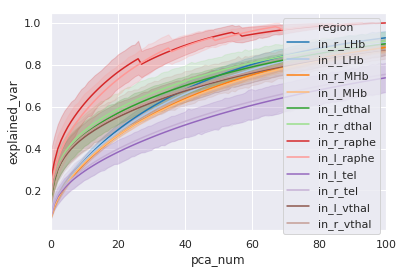

In [266]:
ax = sns.lineplot(x="pca_num", y="explained_var", hue="region", data=avg_sem,
                  palette=sns.color_palette('tab20')[:len(avg_sem["region"].unique())])
ax.set_xlim(0,100)

In [270]:
fig = ax.get_figure()
fig.savefig("pca_by_fish.svg")

In [ ]:
def plot_pca_over_neurons(region_pca, f):
    N = len(region_pca)
    iterator = enumerate(sorted(region_pca.items(), key=region_letter))
    plt.figure()
    for i, (region, data) in iterator:
        nNeurons = sum(df[region])
        var = np.cumsum(data['explained_var'])
        sns.lineplot(np.arange(1,len(var)+1)/nNeurons,var, label=region,
                     color=sns.color_palette('tab20')[i])
    plt.xlabel("Compression ( # PCs / # neurons)")
    plt.ylabel("Explained variance")
#     plt.xlim(0,100)
    plt.legend(loc='best')
    plt.title(f.fishid)